In [1]:
import pandas as pd
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

In [2]:
data_format1_path = "data_format1"
data_format2_path = "data_format2"
train_format1_path = os.path.join(data_format1_path, "train_format1.csv")
train_format2_path = os.path.join(data_format2_path, "train_format2.csv")
test_format1_path = os.path.join(data_format1_path, "test_format1.csv")
test_format2_path = os.path.join(data_format2_path, "test_format2.csv")
user_info_format1_path = os.path.join(data_format1_path, "user_info_format1.csv") 
user_log_format1_path = os.path.join(data_format1_path, "user_log_format1.csv", ) 

In [3]:
train_format1 = pd.read_csv(train_format1_path)
train_format2 = pd.read_csv(train_format2_path)
test_format1 = pd.read_csv(test_format1_path)
test_format2 = pd.read_csv(test_format2_path)
user_info_format1 = pd.read_csv(user_info_format1_path)
user_log_format1 = pd.read_csv(user_log_format1_path, dtype={'time_stamp': str}).rename(columns={"seller_id": "merchant_id"})

In [5]:
print("len train_format1:", len(train_format1))
print("len train_format2:", len(train_format2))
print("len test_format1:", len(test_format1))
print("len test_format2:", len(test_format2))

len train_format1: 260864
len train_format2: 7030723
len test_format1: 261477
len test_format2: 7027943


In [6]:
print(len(user_log_format1))
#only filter the log with time_stamp 11.11
user_log_format1 = user_log_format1[user_log_format1["time_stamp"] == "1111"]
print(len(user_log_format1))

54925330
10582633


In [7]:
print(user_log_format1.head())

     user_id  item_id  cat_id  merchant_id  brand_id time_stamp  action_type
171   328862   406349    1280         2700    5476.0       1111            0
172   328862   406349    1280         2700    5476.0       1111            0
173   328862   807126    1181         1963    6109.0       1111            0
174   328862   406349    1280         2700    5476.0       1111            2
175   328862   406349    1280         2700    5476.0       1111            0


In [8]:
user_log_format1 = user_log_format1.drop(columns=["action_type", "time_stamp"])

In [4]:
print("user_log_info1 columns: " + str(user_log_format1.columns))

user_log_info1 columns: Index(['user_id', 'item_id', 'cat_id', 'merchant_id', 'brand_id'], dtype='object')


In [ ]:
print(train_format1.head())
print("============================================")
print(train_format1.describe())
print("============================================")
#check for nan
print(train_format1.isnull().sum())
#nan ratio
print(train_format1.isnull().sum()/len(train_format1))

   user_id  merchant_id  label
0    34176         3906      0
1    34176          121      0
2    34176         4356      1
3    34176         2217      0
4   230784         4818      0
             user_id    merchant_id          label
count  260864.000000  260864.000000  260864.000000
mean   211889.321420    2540.292363       0.061151
std    122399.488027    1451.207514       0.239607
min         1.000000       2.000000       0.000000
25%    105488.000000    1340.000000       0.000000
50%    211927.500000    2482.000000       0.000000
75%    317670.500000    3898.000000       0.000000
max    424170.000000    4993.000000       1.000000
user_id        0
merchant_id    0
label          0
dtype: int64
user_id        0.0
merchant_id    0.0
label          0.0
dtype: float64


In [ ]:
# print(train_format2.head())
# print("============================================")
# print(train_format2.describe())
# print("============================================")
# #check for nan
# print(train_format2.isnull().sum())
# #nan ratio
# print(train_format2.isnull().sum()/len(train_format2))

   user_id  age_range  gender  merchant_id  label  \
0    34176        6.0     0.0          944     -1   
1    34176        6.0     0.0          412     -1   
2    34176        6.0     0.0         1945     -1   
3    34176        6.0     0.0         4752     -1   
4    34176        6.0     0.0          643     -1   

                                        activity_log  
0                            408895:1505:7370:1107:0  
1  17235:1604:4396:0818:0#954723:1604:4396:0818:0...  
2  231901:662:2758:0818:0#231901:662:2758:0818:0#...  
3                             174142:821:6938:1027:0  
4                             716371:1505:968:1024:3  
            user_id     age_range        gender   merchant_id         label
count  7.030723e+06  7.011343e+06  6.969011e+06  7.030723e+06  7.030723e+06
mean   2.120120e+05  3.106246e+00  3.036947e-01  2.455233e+03 -9.606277e-01
std    1.223200e+05  1.914345e+00  5.319517e-01  1.456245e+03  2.058154e-01
min    1.000000e+00  0.000000e+00  0.000000e+00

In [6]:
print(test_format1.head())
print("============================================")
test_format1.describe()
print("============================================")
print(test_format1.isnull().sum())
print(test_format1.isnull().sum()/len(test_format1))

   user_id  merchant_id  prob
0   163968         4605   NaN
1   360576         1581   NaN
2    98688         1964   NaN
3    98688         3645   NaN
4   295296         3361   NaN
user_id             0
merchant_id         0
prob           261477
dtype: int64
user_id        0.0
merchant_id    0.0
prob           1.0
dtype: float64


In [ ]:
# print(test_format2.head())
# print("============================================")
# test_format2.describe()
# print("============================================")
# print(test_format2.isnull().sum())
# print(test_format2.isnull().sum()/len(test_format2))

   user_id  age_range  gender  merchant_id  label  \
0   163968        0.0     0.0         4378   -1.0   
1   163968        0.0     0.0         2300   -1.0   
2   163968        0.0     0.0         1551   -1.0   
3   163968        0.0     0.0         4343   -1.0   
4   163968        0.0     0.0         4911   -1.0   

                                        activity_log  
0                             101206:812:6968:0614:0  
1  588758:844:3833:0618:0#71782:844:3833:1111:2#7...  
2  312747:243:1954:0627:0#312747:243:1954:0627:0#...  
3                            932390:1612:3201:0628:0  
4                             957657:662:3089:0612:0  
user_id              0
age_range        19420
gender           63250
merchant_id          0
label           261477
activity_log      3006
dtype: int64
user_id         0.000000
age_range       0.002763
gender          0.009000
merchant_id     0.000000
label           0.037205
activity_log    0.000428
dtype: float64


In [8]:
print(user_info_format1.head())
print("============================================")
print(user_info_format1.describe())
print("============================================")
print(user_info_format1.isnull().sum())
print(user_info_format1.isnull().sum()/len(user_info_format1))

   user_id  age_range  gender
0   376517        6.0     1.0
1   234512        5.0     0.0
2   344532        5.0     0.0
3   186135        5.0     0.0
4    30230        5.0     0.0
             user_id      age_range         gender
count  424170.000000  421953.000000  417734.000000
mean   212085.500000       2.930262       0.341179
std    122447.476178       1.942978       0.524112
min         1.000000       0.000000       0.000000
25%    106043.250000       2.000000       0.000000
50%    212085.500000       3.000000       0.000000
75%    318127.750000       4.000000       1.000000
max    424170.000000       8.000000       2.000000
user_id         0
age_range    2217
gender       6436
dtype: int64
user_id      0.000000
age_range    0.005227
gender       0.015173
dtype: float64


In [9]:
print(user_log_format1.head())
print("============================================")
print(user_log_format1.describe())
print("============================================")
print(user_log_format1.isnull().sum())
print(user_log_format1.isnull().sum()/len(user_log_format1))

   user_id  item_id  cat_id  merchant_id  brand_id  time_stamp  action_type
0   328862   323294     833         2882    2661.0         829            0
1   328862   844400    1271         2882    2661.0         829            0
2   328862   575153    1271         2882    2661.0         829            0
3   328862   996875    1271         2882    2661.0         829            0
4   328862  1086186    1271         1253    1049.0         829            0
            user_id       item_id        cat_id   merchant_id      brand_id  \
count  5.492533e+07  5.492533e+07  5.492533e+07  5.492533e+07  5.483432e+07   
mean   2.121568e+05  5.538613e+05  8.770308e+02  2.470941e+03  4.153348e+03   
std    1.222872e+05  3.221459e+05  4.486269e+02  1.473310e+03  2.397679e+03   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    1.063360e+05  2.731680e+05  5.550000e+02  1.151000e+03  2.027000e+03   
50%    2.126540e+05  5.555290e+05  8.210000e+02  2.459000e+03  4.06500

In [15]:
# does there exist user_id and merchant_id pair that appears in test set
print(pd.merge(train_format1[["user_id", "merchant_id"]].drop_duplicates(), test_format1[["user_id", "merchant_id"]].drop_duplicates(), how="inner", on=["user_id", "merchant_id"]))
print(pd.merge(train_format1[["user_id", "merchant_id"]].drop_duplicates(), test_format1[["user_id", "merchant_id"]].drop_duplicates(), how="inner", on=["user_id"]))
print(pd.merge(train_format1[["user_id", "merchant_id"]].drop_duplicates(), test_format1[["user_id", "merchant_id"]].drop_duplicates(), how="inner", on=["merchant_id"]))

Empty DataFrame
Columns: [user_id, merchant_id]
Index: []
Empty DataFrame
Columns: [user_id, merchant_id_x, merchant_id_y]
Index: []
           user_id_x  merchant_id  user_id_y
0              34176         3906     325008
1              34176         3906     282768
2              34176         3906     187542
3              34176         3906      97206
4              34176         3906     153795
...              ...          ...        ...
150064189      41078         3966     395099
150064190      41078         3966     218750
150064191      76387         2350     174237
150064192      76387         2350       3123
150064193      76387         2350      66667

[150064194 rows x 3 columns]


In [25]:
print(user_log_format1[user_log_format1["user_id"] == 360576])

         user_id  item_id  cat_id  merchant_id  brand_id
4930955   360576   991507    1142         4044      82.0
4930956   360576   948181     614         1581    4066.0
4930958   360576  1111020     614         1581    4066.0
4930959   360576   755622     614         1783    5041.0
4930960   360576   294442     614         1581    4066.0
4930961   360576   864510     614         1581    4066.0
4930962   360576   326679     614         1581    4066.0
4930963   360576   720542     748         2582    7208.0
4930964   360576   755622     614         1783    5041.0
4930967   360576   794107     614         1581    4066.0
4930969   360576   864510     614         1581    4066.0
4930970   360576   755622     614         1783    5041.0
4930971   360576   755622     614         1783    5041.0
4930973   360576   982117     632         1581    4066.0
4930974   360576    61318     229         1581    4066.0
4930975   360576   164776     389         3848    4452.0
4930976   360576  1091811    11

In [26]:
test_format1[~test_format1['user_id'].isin(user_log_format1['user_id'])]

,user_id,merchant_id,prob


In [4]:
#verify user activity of test users all exist inside the data
missing_keys = test_format1[~test_format1[['user_id', 'merchant_id']].isin(user_log_format1[['user_id', 'merchant_id']])]
missing_keys_user_only = test_format1[~test_format1['user_id'].isin(user_log_format1['user_id'])]
missing_keys_merchant_only = test_format1[~test_format1[ 'merchant_id'].isin(user_log_format1['merchant_id'])]
print("Original test length: ", len(test_format1))
print("User merchant pair in test not appear in log: ", len(missing_keys.drop_duplicates()))
print("User in test not appear in log: ", len(missing_keys_user_only.drop_duplicates()))
print("merchant in test not appear in log: ", len(missing_keys_merchant_only.drop_duplicates()))

Original test length:  261477
User merchant pair in test not appear in log:  261477
User in test not appear in log:  0
merchant in test not appear in log:  0


In [22]:
#unique value of user id
train_format1['user_id'].nunique()
print("Train user id Uniqueness ratio: ", train_format1['user_id'].nunique() / len(train_format1['user_id']))
print("Test user id Uniqueness ratio: ", test_format1['user_id'].nunique() / len(test_format1['user_id']))

print("Train merchant id Uniqueness ratio: ", train_format1['merchant_id'].nunique() / len(train_format1['merchant_id']))
print("Test merchant Uniqueness ratio: ", test_format1['merchant_id'].nunique() / len(test_format1['merchant_id']))

Train user id Uniqueness ratio:  0.8129216756624141
Test user id Uniqueness ratio:  0.8111918065451263
Train merchant id Uniqueness ratio:  0.007639996319921492
Test merchant Uniqueness ratio:  0.007622085307694367


In [25]:
#duplicate data in train_format1 between merchant and user id
print("Amount of user id and merchant id duplicated in train: ", train_format1[['user_id', 'merchant_id']].duplicated().sum())
print("Amount of user id and merchant id duplicated in test: ",test_format1[['user_id', 'merchant_id']].duplicated().sum())

Amount of user id and merchant id duplicated in train:  0
Amount of user id and merchant id duplicated in test:  0


In [28]:
#check if all label -1 in format_2 is all contains in user_log format 1
tmp = test_format2[test_format2["label"] == -1][["user_id", "merchant_id"]]
mask = tmp.isin(user_log_format1[["user_id", "merchant_id"]]).all(axis=1)
print("total of merchant and user in test format 2: ", len(tmp))
print("======= Mask ==========")
print(mask)
print("Amount that is contained in format1: ", len(tmp[mask]))
del tmp

total of merchant and user in test format 2:  6766466
======= Mask ==========
0          False
1          False
2          False
3          False
4          False
           ...  
7027938    False
7027939    False
7027940    False
7027941    False
7027942    False
Length: 6766466, dtype: bool
Amount that is contained in format1:  0


In [5]:
#join the tables
train_format1 = pd.merge(train_format1, user_log_format1, on=['user_id', 'merchant_id'], how='left')
print(train_format1.head())
print("====")
test_format1 = pd.merge(test_format1, user_log_format1, on=['user_id', 'merchant_id'], how='left')
print(test_format1.head())
print("====")
train_format1 = pd.merge(train_format1, user_info_format1, on='user_id', how='left')
print(train_format1.head())
print("====")
test_format1 = pd.merge(test_format1, user_info_format1, on='user_id', how='left')
print(test_format1.head())
print("====")
#erase the original dataframe
del user_info_format1
del user_log_format1

   user_id  merchant_id  label  item_id  cat_id  brand_id time_stamp  \
0    34176         3906      0   757713     821    6268.0       1111   
1    34176         3906      0   757713     821    6268.0       1111   
2    34176         3906      0   757713     821    6268.0       1111   
3    34176         3906      0   757713     821    6268.0       1111   
4    34176          121      0   800752    1028    2337.0       1111   

   action_type  
0            2  
1            0  
2            0  
3            0  
4            2  
====
   user_id  merchant_id  prob  item_id  cat_id  brand_id time_stamp  \
0   163968         4605   NaN   772645    1368    7622.0       1111   
1   163968         4605   NaN   772645    1368    7622.0       1111   
2   360576         1581   NaN   948181     614    4066.0       1111   
3   360576         1581   NaN  1111020     614    4066.0       1111   
4   360576         1581   NaN   294442     614    4066.0       1111   

   action_type  
0            2  

In [6]:
print(len(train_format1))
print(len(test_format1))

1653030
1650271


In [14]:
# are all users and merchant in tests appear in trains
print("Test user id not in train: ", len(set(test_format1['user_id']) - set(train_format1['user_id'])))
print("Test merchant id not in train: ", len(set(test_format1['merchant_id']) - set(train_format1['merchant_id'])))
print("Category not in train: ", len(set(test_format1['cat_id']) - set(train_format1['cat_id'])))
print("Brand not in train: ", len(set(test_format1['brand_id']) - set(train_format1['brand_id'])))

Test user id not in train:  212108
Test merchant id not in train:  1
Category not in train:  86
Brand not in train:  3403


In [9]:
print(test_format2)

         user_id  age_range  gender  merchant_id  label  \
0         163968        0.0     0.0         4378   -1.0   
1         163968        0.0     0.0         2300   -1.0   
2         163968        0.0     0.0         1551   -1.0   
3         163968        0.0     0.0         4343   -1.0   
4         163968        0.0     0.0         4911   -1.0   
...          ...        ...     ...          ...    ...   
7027938    32639        0.0     0.0         2550   -1.0   
7027939    32639        0.0     0.0         1364   -1.0   
7027940    32639        0.0     0.0          503   -1.0   
7027941    32639        0.0     0.0         2286   -1.0   
7027942    32639        0.0     0.0         1506   -1.0   

                                              activity_log  
0                                   101206:812:6968:0614:0  
1        588758:844:3833:0618:0#71782:844:3833:1111:2#7...  
2        312747:243:1954:0627:0#312747:243:1954:0627:0#...  
3                                  932390:1612:

,user_id,merchant_id
0,163968,4378
1,163968,2300
2,163968,1551
3,163968,4343
4,163968,4911
...,...,...
7027938,32639,2550
7027939,32639,1364
7027940,32639,503
7027941,32639,2286


# 1. Preprocess Data

# 2. Matrix Decomposition, with sklearn

## Construct the embedding matrix of user_id (row), and merchant (column), and embedding vector (latent_size), for each 

In [8]:
print(train_format1[["user_id", "merchant_id"]].value_counts())

user_id  merchant_id
391188   1102           3904
109962   1102           1253
368492   4044            683
100051   1457            629
351957   1963            612
                        ... 
108932   2031              1
         3090              1
253012   3205              1
108939   3862              1
239925   2273              1
Length: 260864, dtype: int64


In [ ]:

# Prepare interaction matrices from the training data
def prepare_interaction_matrix(train_data, test_data, latent_size=20, sample_top_occurence=None):
    """
    Prepares a sparse interaction matrix for the given row and column.
    """
    row_encoder = LabelEncoder()
    col_encoder = LabelEncoder()
    brand_encoder = LabelEncoder()
    cat_encoder = LabelEncoder()

    #merge to get the embedding in one space
    train_test_data = train_data.concat(test_data)


    train_test_data['user_id_enc'] = row_encoder.fit_transform(train_test_data['user_id'])
    train_test_data['merchant_id_enc'] = col_encoder.fit_transform(train_test_data['merchant_id'])
    train_test_data['brand_id_enc'] = brand_encoder.fit_transform(train_test_data['brand_id'])
    train_test_data['cat_id_enc'] = cat_encoder.fit_transform(train_test_data['cat_id'])


    value_counts_user_merchants = train_test_data[['user_id_enc', 'merchant_id_enc']].value_counts()
    value_counts_user_brands = train_test_data[['user_id_enc', 'brand_id_enc']].value_counts()
    value_counts_user_cats = train_test_data[['user_id_enc', 'cat_id_enc']].value_counts()\
    
    #arrange into csr matrix
    csr_matrix_user_merchants = csr_matrix()
    value_counts_user_merchants = 
    print("Value counts: =====================================")
    print(value_counts)
    if sample_top_occurence is not None:
        #only pick top k interaction
        top_occurence = value_counts[:sample_top_occurence]
        train_data = train_data.set_index(['user_id_enc', 'merchant_id_enc']).loc[top_occurence.index].reset_index()
    
    #group the user_id and merchant id brand and cat
    brand_group = train_data.groupby(['user_id_enc', 'merchant_id_enc'])['brand_id_enc'].unique()
    
    print("Brand group: =====================================")
    print(brand_group)

    print("Cat group: =====================================")
    cat_group = train_data.groupby(['user_id_enc', 'merchant_id_enc'])['cat_id_enc'].unique()

    # metadata:
    metadata = {
        'row_encoder': row_encoder,
        'col_encoder': col_encoder,
        'brand_encoder': brand_encoder,
        'cat_encoder': cat_encoder,
        'value_counts': value_counts,
        'brand_group': brand_group,
        'cat_group': cat_group
    }

    #create embedding matrices for user, merchant

    return None, metadata

prepare_interaction_matrix(train_data=train_format1, latent_size=20, sample_top_occurence=None)

Value counts: =====================================
user_id_enc  merchant_id_enc
195520       419                3904
55077        419                1253
184303       1575                683
50106        554                 629
176047       757                 612
                                ... 
54564        783                   1
             1210                  1
126495       1254                  1
54570        1502                  1
119918       885                   1
Length: 260864, dtype: int64
Brand group: =====================================
user_id_enc  merchant_id_enc
0            378                [2447]
1            446                 [274]
2            510                [3032]
             1661               [1166]
3            439                [1635]
                                 ...  
212057       652                [2854]
212058       1488                [808]
212059       229                 [139]
212060       451                 [827]
212061       

(None,
 {'row_encoder': LabelEncoder(),
  'col_encoder': LabelEncoder(),
  'brand_encoder': LabelEncoder(),
  'cat_encoder': LabelEncoder(),
  'value_counts': user_id_enc  merchant_id_enc
  195520       419                3904
  55077        419                1253
  184303       1575                683
  50106        554                 629
  176047       757                 612
                                  ... 
  54564        783                   1
               1210                  1
  126495       1254                  1
  54570        1502                  1
  119918       885                   1
  Length: 260864, dtype: int64,
  'brand_group': user_id_enc  merchant_id_enc
  0            378                [2447]
  1            446                 [274]
  2            510                [3032]
               1661               [1166]
  3            439                [1635]
                                   ...  
  212057       652                [2854]
  212058       148

In [ ]:
from scipy.sparse import csr_matrix


# Create user-merchant interaction matrix
interaction_matrix, user_encoder, merchant_encoder = prepare_interaction_matrix(
    train_format1, row_name='user_id', col_name='merchant_id'
)

# Shape of the matrix
interaction_matrix_shape = interaction_matrix.shape

interaction_matrix_shape


embedding_latent_dim = 20

# Apply NMF to derive merchant embeddings
num_components = 20  # Number of latent features
nmf_model = NMF(n_components=num_components, init='random', random_state=42, max_iter=500)

# Fit the NMF model on the interaction matrix
merchant_embeddings = nmf_model.fit_transform(interaction_matrix)
user_embeddings = nmf_model.components_.T

# Dimensions of the embeddings
merchant_embeddings_shape = merchant_embeddings.shape
user_embeddings_shape = user_embeddings.shape

merchant_embeddings_shape, user_embeddings_shape

In [ ]:
# Extract `seller_id` embeddings (merchant embeddings are already associated with seller_id)
train_data['seller_id'] = merchant_encoder.inverse_transform(train_data['col_index'])

# Now prepare for category (cat_id) and brand (brand_id) embeddings
# Assuming the original dataset has `cat_id` and `brand_id` to compute their averages
def compute_average_embeddings(data, target_col, embedding_matrix, encoder):
    """
    Computes average embeddings for a target column based on the embedding matrix.
    If multiple embeddings exist for a single target (e.g., user interaction with multiple categories),
    the mean is calculated.
    """
    data['target_index'] = encoder.transform(data[target_col])
    grouped = data.groupby('user_id')['target_index'].apply(list)

    average_embeddings = []
    for user, indices in grouped.items():
        if indices:  # Check for valid indices
            average_embeddings.append(embedding_matrix[indices].mean(axis=0))
        else:
            average_embeddings.append([0] * embedding_matrix.shape[1])  # Zero vector if no indices

    return pd.DataFrame(average_embeddings, index=grouped.index)

# Encode `cat_id` and `brand_id` (dummy for demonstration as we lack the columns here)
# Assume `cat_id` and `brand_id` are numeric in real data
cat_encoder = LabelEncoder()
brand_encoder = LabelEncoder()

# Simulating `cat_id` and `brand_id` in train_data (mock process as real columns are absent)
train_data['cat_id'] = train_data['merchant_id'] % 100  # Mock category IDs
train_data['brand_id'] = train_data['merchant_id'] % 50  # Mock brand IDs

# Encode categorical features
train_data['cat_index'] = cat_encoder.fit_transform(train_data['cat_id'])
train_data['brand_index'] = brand_encoder.fit_transform(train_data['brand_id'])

# Simulate embeddings for categories and brands based on merchant embeddings
category_embeddings = merchant_embeddings.copy()  # Mock: categories share merchant embeddings
brand_embeddings = merchant_embeddings.copy()     # Mock: brands share merchant embeddings

# Compute average embeddings for categories and brands
average_cat_embeddings = compute_average_embeddings(train_data, 'cat_id', category_embeddings, cat_encoder)
average_brand_embeddings = compute_average_embeddings(train_data, 'brand_id', brand_embeddings, brand_encoder)

# Dimensions of the average embeddings
average_cat_embeddings_shape = average_cat_embeddings.shape
average_brand_embeddings_shape = average_brand_embeddings.shape

average_cat_embeddings_shape, average_brand_embeddings_shape


In [39]:
#how many users in train appear in test set
print("Amount of user id duplicated in train and test: ", train_format1['user_id'].isin(test_format1['user_id']).sum())
print("Ratio toward the whole test: ", train_format1['user_id'].isin(test_format1['user_id']).sum() / len(test_format1['user_id']))

#how many merchants in train appear in test set
print("Amount of merchant id duplicated in train and test: ", train_format1['merchant_id'].isin(test_format1['merchant_id']).sum())
print("Ratio toward the whole test: ", train_format1['merchant_id'].isin(test_format1['merchant_id']).sum() / len(test_format1['merchant_id']))

Amount of user id duplicated in train and test:  0
Ratio toward the whole test:  0.0
Amount of merchant id duplicated in train and test:  260863
Ratio toward the whole test:  0.9976518011144384


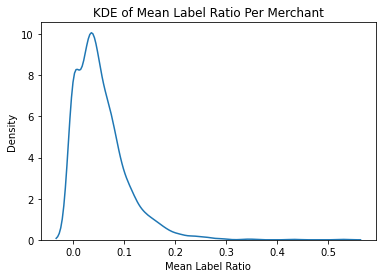

In [46]:
#for each merchant, how many users get the label 1 (ratio)
merchant_ratios = train_format1['label'].groupby(train_format1['merchant_id']).mean()

sns.kdeplot(merchant_ratios, bw_adjust=1)  # bw_adjust adjusts the bandwidth; tweak as needed
plt.title("KDE of Mean Label Ratio Per Merchant")
plt.xlabel("Mean Label Ratio")
plt.ylabel("Density")
plt.show()

In [27]:
# class balance or imbalance
print("Train label 0 ratio: ", train_format1[train_format1['label'] == 0].shape[0] / len(train_format1['label']))

Train label 0 ratio:  0.9388493621197253


In [35]:
def training_iteration_lightgbm(train_data, val_data, train_target, val_target, params):
    lgbm_train_data = lgb.Dataset(train_data, label=train_target)
    lgbm_val_data = lgb.Dataset(val_data, label=val_target, reference=train_data)
    model = lgb.train(params, lgbm_train_data, num_boost_round=1000, valid_sets=[lgbm_val_data], early_stopping_rounds=50, verbose_eval=50)
    return model

In [ ]:
#lightgbm baseline
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
}
baseline_train_data = train_format1.drop(['label'], axis=1)

#preprocessing null in age range
baseline_user_info = 
baseline_train_data = baseline_train_data.merge(user_info_format1, on='user_id', how='left')
baseline_train_target = train_format1['label']

baseline_train_data.join(other, lsuffix='_caller', rsuffix='_other')